<a href="https://colab.research.google.com/github/lggomezupb/Machine-learning-application-to-portfolio-allocation/blob/main/Markowitz_Portfolio_simulationipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from math import sqrt
from scipy import stats
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
import pandas_datareader
import math
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
from prettytable import PrettyTable
import cvxpy as cvx

In [ ]:
#Total years of traing model
years=2
# Define the end date
fecha = "2022-01-02"
end=fecha
# Convert the end date string to a datetime object
end_date = datetime.strptime(end, "%Y-%m-%d")
# Calculate the start date as one year before the end date
start_date = end_date - timedelta(days=365*years)
# Convert the start date to a string in the same format as the end date
start = start_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

Start Date: 2020-01-03
End Date: 2022-01-02


In [ ]:
## define the stocks for our portfolio (via tickers) ###
assets = [ #Healthcare
          "JNJ", #(Johnson & Johnson)
          "PFE", #(Pfizer Inc.)
          "MRK", #(Merck & Co. Inc.)
          "LLY", #(Eli Lilly and company)
          "UNH", #(UnitedHealth Group Incorporated)
          "AMGN", #(Amgen Inc.)
          #Technology
          "MSFT", #(Microsoft Corporation)
          "GOOGL", #(Alphabet Inc. - Google)
          "META", #(Meta Platforms Inc. - Facebook)
          "NVDA", #(Nvidia)
          "AMD", #(Advanced micro devices)
          "TSLA", #(Tesla, Inc.)
          "CRM", #(Salesforce.com Inc.)
          # Finance
          "JPM", #(JPMorgan Chase & Co.)
          "MA", #(Mastercard)
          "BX", #(Blackstone)
          "AXP", #(American Express)
          "GS", #(The Goldman Sachs Group, Inc.)
          "BAC", #(Bank of America Corporation)
          "V", #(Visa Inc.)
          #Consumer goods
          "PG", #(Procter & Gamble Company)
          "KO", #(The Coca-Cola Company)
          "NKE", #(Nike, Inc.)
          "MCD", #(McDonald's Corporation)
          #Energy
          "XOM", #(Exxon Mobil Corporation)
          "CVX", #(Chevron Corporation)
          "SHEL", #(Royal Dutch Shell plc)
          "BP", #(BP p.l.c.)
          "COP", #(ConocoPhillips)
          #Retail
          "AMZN", #(Amazon.com, Inc.)
          "WMT", #(Walmart Inc.)
          "TGT", #(Target Corporation)
          "COST", #(Costco Wholesale Corporation)
          "HD", #(The Home Depot, Inc.)
          #Telecommunications
          "T", #(AT&T Inc.)
          "VZ", #(Verizon Communications Inc.)
          "TMUS", #(T-Mobile US, Inc.)
          #Utilities
          "NEE", #(NextEra Energy, Inc.)
          "DUK", #(Duke Energy Corporation)
          "SO", #(The Southern Company)
          "NRG", #(NRG Energy)
          "EXC", #(Exelon Corporation)
          "AEP", #(American Electric Power Company, Inc.)
          #Real Estate
          "SPG", #(Simon Property Group, Inc.)
          "AMT", #(American Tower Corporation)
          "EQIX", #(Equinix, Inc.)
          "PSA", #(Public Storage)
          "WELL", #(Welltower Inc.)
          #Transportation
          "UPS", #(United Parcel Service, Inc.)
          "FDX", #(FedEx Corporation)
          "DAL", #(Delta Air Lines, Inc.)
          "AAL", #(American Airlines Group Inc.)
          "BLDR", #(Builders first source)
          "UBER", #(Uber Technologies, Inc.)
          #"ROAD", #(Construction Partners, Inc)
          #cripto
          "BTC-USD", #Bitcoin
          "ETH-USD" #Ethereum
          ]

assets =sorted(assets)
# Acquire data
df_prices = yf.download(assets,start=start,end=end)['Adj Close']
df_prices = df_prices.dropna()

[*********************100%%**********************]  56 of 56 completed


In [ ]:
def bl(df_prices):
    # We transform the data to its logarithmic returns
    df = np.log(df_prices).diff()
    # Drop the first row because we loose information for the logarithmic return.
    df = df.dropna()  # this is a dataframe

    # Compute the Expected Returns, we multiply daily return by 252
    #because there are 252 business days in the US.
    exp_returns = df.mean()*252
    # compute the covariance matrix
    cova = df.cov()*252
    #number of assets
    m=exp_returns.shape[0]
    # WANT: optimal portfolio with the following constraints
    # 1. no short sales are allowed  that is the weights for all stocks are >=0
    # 2. Maximum value of 15%
    # 3. Minimum value of 5%
    # 4. The asset could take the minimun value or Zero

    #def optimize_portfolio(exp_returns, index_weights, scale=.0000):
    Q = np.array(cova)   # Q is variance-covariance matrix of assets
    q = np.array(exp_returns) # q is the exptected returns of assets

    #  Constraints

    h =np.ones(m)*0.02  # Minimum value]
    k=np.zeros(m)       # For values zero
    j =np.ones(m)*0.12   # Maximum value

    #
    # Define and solve the quadratic problem using CVXPY:
    # ===================================================
    x = cvx.Variable(m)
    prob = cvx.Problem(cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x),
                [x >= cvx.multiply(k, h), # Give a minimum value and also posivility of choose 0
                  x <= j, # Maximum value
                  x >= 0,
                  cvx.sum(x) == 1]) # Constrain sum 1
    prob.solve()
    #retrieve the weights of the optimized portfolio
    x_values = x.value

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(x_values) < threshold, 0, x_values)

    return weights


In [ ]:
#Number of periods
periods=26
#Number of days of the period
leng_period=30


assets =sorted(assets)
# Acquire data
df_prices = yf.download(assets,start=start,end=end)['Adj Close']
df_prices = df_prices.dropna()

[*********************100%%**********************]  56 of 56 completed


In [ ]:
weights=[]
table = PrettyTable()
table.field_names = ["Start Date", "End Date"]
for i in range(periods):
  # Convert the end date string to a datetime object
  end_date = datetime.strptime(end, "%Y-%m-%d")
  # Calculate the start date as one year before the end date
  start_date = end_date - timedelta(days=365*years)
  # Convert the start date to a string in the same format as the end date
  start = start_date.strftime("%Y-%m-%d")
  end = end_date.strftime("%Y-%m-%d")
  print(start, end)
  table.add_row([start, end])
  df_prices = yf.download(assets,start=start,end=end)['Adj Close']
  df_prices = df_prices.dropna()
  weight=bl(df_prices)
  # Append the weights for this period to the matrix
  weights.append(weight)
  end_date += timedelta(days=leng_period)
  end = end_date.strftime("%Y-%m-%d")

print(table)

[                       0%%                      ]

2020-01-03 2022-01-02


[*********************100%%**********************]  56 of 56 completed


2020-02-02 2022-02-01


[*********************100%%**********************]  56 of 56 completed


2020-03-03 2022-03-03


[*********************100%%**********************]  56 of 56 completed


2020-04-02 2022-04-02


[*********************100%%**********************]  56 of 56 completed


2020-05-02 2022-05-02


[*********************100%%**********************]  56 of 56 completed


2020-06-01 2022-06-01


[*********************100%%**********************]  56 of 56 completed


2020-07-01 2022-07-01


[*********************100%%**********************]  56 of 56 completed


2020-07-31 2022-07-31


[*********************100%%**********************]  56 of 56 completed
[                       0%%                      ]

2020-08-30 2022-08-30


[*********************100%%**********************]  56 of 56 completed


2020-09-29 2022-09-29


[*********************100%%**********************]  56 of 56 completed


2020-10-29 2022-10-29


[*********************100%%**********************]  56 of 56 completed


2020-11-28 2022-11-28


[*********************100%%**********************]  56 of 56 completed
[                       0%%                      ]

2020-12-28 2022-12-28


[*********************100%%**********************]  56 of 56 completed


2021-01-27 2023-01-27


[*********************100%%**********************]  56 of 56 completed


2021-02-26 2023-02-26


[*********************100%%**********************]  56 of 56 completed


2021-03-28 2023-03-28


[*********************100%%**********************]  56 of 56 completed
[                       0%%                      ]

2021-04-27 2023-04-27


[*********************100%%**********************]  56 of 56 completed


2021-05-27 2023-05-27


[*********************100%%**********************]  56 of 56 completed


2021-06-26 2023-06-26


[*********************100%%**********************]  56 of 56 completed


2021-07-26 2023-07-26


[*********************100%%**********************]  56 of 56 completed
[                       0%%                      ]

2021-08-25 2023-08-25


[*********************100%%**********************]  56 of 56 completed


2021-09-24 2023-09-24


[*********************100%%**********************]  56 of 56 completed
[                       0%%                      ]

2021-10-24 2023-10-24


[*********************100%%**********************]  56 of 56 completed


2021-11-23 2023-11-23


[*********************100%%**********************]  56 of 56 completed
[                       0%%                      ]

2021-12-23 2023-12-23


[*********************100%%**********************]  56 of 56 completed


2022-01-22 2024-01-22


[*********************100%%**********************]  56 of 56 completed


+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2020-01-03 | 2022-01-02 |
| 2020-02-02 | 2022-02-01 |
| 2020-03-03 | 2022-03-03 |
| 2020-04-02 | 2022-04-02 |
| 2020-05-02 | 2022-05-02 |
| 2020-06-01 | 2022-06-01 |
| 2020-07-01 | 2022-07-01 |
| 2020-07-31 | 2022-07-31 |
| 2020-08-30 | 2022-08-30 |
| 2020-09-29 | 2022-09-29 |
| 2020-10-29 | 2022-10-29 |
| 2020-11-28 | 2022-11-28 |
| 2020-12-28 | 2022-12-28 |
| 2021-01-27 | 2023-01-27 |
| 2021-02-26 | 2023-02-26 |
| 2021-03-28 | 2023-03-28 |
| 2021-04-27 | 2023-04-27 |
| 2021-05-27 | 2023-05-27 |
| 2021-06-26 | 2023-06-26 |
| 2021-07-26 | 2023-07-26 |
| 2021-08-25 | 2023-08-25 |
| 2021-09-24 | 2023-09-24 |
| 2021-10-24 | 2023-10-24 |
| 2021-11-23 | 2023-11-23 |
| 2021-12-23 | 2023-12-23 |
| 2022-01-22 | 2024-01-22 |
+------------+------------+


In [ ]:
start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

initial_market_prices = yf.download("^GSPC",start=start,end=end)['Adj Close']
initial_df_prices = yf.download(assets,start=start,end=end)['Adj Close']
initial_df_prices = initial_df_prices.dropna()

[*********************100%%**********************]  1 of 1 completed

Start Date: 2022-01-02
End Date: 2024-02-21



[*********************100%%**********************]  56 of 56 completed


In [ ]:
Total_invest=1_000
Total_invest_market=Total_invest
bl_portfolio = []
market=[]
portfolio=[]
otro=[]
table = PrettyTable()
table.field_names = ["Start Date", "End Date"]
for x in range(periods):
    # Convert the start date string to a datetime object
    start_date = datetime.strptime(start, "%Y-%m-%d")
    #sum leng period to the end date
    end_date = start_date + timedelta(days=leng_period)
    # Convert the end date to a string in the same format as the end date
    end = end_date.strftime("%Y-%m-%d")
    start= start_date.strftime("%Y-%m-%d")
    print(start, end)
    table.add_row([start, end])
    market_prices = yf.download("^GSPC",start=start,end=end)['Adj Close']

    df_prices = yf.download(assets,start=start,end=end)['Adj Close']
    df_prices = df_prices.dropna()
    portfolio= np.zeros(len(df_prices))
    # Loop through each asset and its weight, and calculate the contribution to the portfolio
    for i in range(len(assets)):
        asset_name = assets[i]
        asset_price = df_prices[asset_name]/df_prices[asset_name][0]
        asset_weight = weights[x][i]
        portfolio += asset_price * asset_weight
    portf = portfolio*Total_invest
    # Recalculation of the new total invest by the end of the period
    Total_invest=portfolio[-1]*Total_invest
    bl_portfolio.append(portf)
    market_prices=market_prices/initial_market_prices[0]*Total_invest_market
    market.append(market_prices)
    start_date += timedelta(days=leng_period)
    start= start_date.strftime("%Y-%m-%d")
print(table)

[*********************100%%**********************]  1 of 1 completed


2022-01-02 2022-02-01


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2022-02-01 2022-03-03


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2022-03-03 2022-04-02


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2022-04-02 2022-05-02


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2022-05-02 2022-06-01


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed

2022-06-01 2022-07-01



[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed

2022-07-01 2022-07-31



[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed

2022-07-31 2022-08-30



[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2022-08-30 2022-09-29


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2022-09-29 2022-10-29


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed

2022-10-29 2022-11-28



[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2022-11-28 2022-12-28


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2022-12-28 2023-01-27


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2023-01-27 2023-02-26


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed

2023-02-26 2023-03-28



[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2023-03-28 2023-04-27


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2023-04-27 2023-05-27


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2023-05-27 2023-06-26


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2023-06-26 2023-07-26


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2023-07-26 2023-08-25


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed

2023-08-25 2023-09-24



[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2023-09-24 2023-10-24


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed

2023-10-24 2023-11-23



[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2023-11-23 2023-12-23


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2023-12-23 2024-01-22


[*********************100%%**********************]  56 of 56 completed
[*********************100%%**********************]  1 of 1 completed


2024-01-22 2024-02-21


[*********************100%%**********************]  56 of 56 completed


+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2022-01-02 | 2022-02-01 |
| 2022-02-01 | 2022-03-03 |
| 2022-03-03 | 2022-04-02 |
| 2022-04-02 | 2022-05-02 |
| 2022-05-02 | 2022-06-01 |
| 2022-06-01 | 2022-07-01 |
| 2022-07-01 | 2022-07-31 |
| 2022-07-31 | 2022-08-30 |
| 2022-08-30 | 2022-09-29 |
| 2022-09-29 | 2022-10-29 |
| 2022-10-29 | 2022-11-28 |
| 2022-11-28 | 2022-12-28 |
| 2022-12-28 | 2023-01-27 |
| 2023-01-27 | 2023-02-26 |
| 2023-02-26 | 2023-03-28 |
| 2023-03-28 | 2023-04-27 |
| 2023-04-27 | 2023-05-27 |
| 2023-05-27 | 2023-06-26 |
| 2023-06-26 | 2023-07-26 |
| 2023-07-26 | 2023-08-25 |
| 2023-08-25 | 2023-09-24 |
| 2023-09-24 | 2023-10-24 |
| 2023-10-24 | 2023-11-23 |
| 2023-11-23 | 2023-12-23 |
| 2023-12-23 | 2024-01-22 |
| 2024-01-22 | 2024-02-21 |
+------------+------------+


In [ ]:
for i in range(periods):
    SP500_earnings = (market[i][-1]-market[i][0])/market[i][0]
    print("Earning % S&P500:", SP500_earnings*100)
    BL_earnings=(bl_portfolio[i][-1]-bl_portfolio[i][0])/bl_portfolio[i][0]
    print("Earning % Markowitz portfolio:", BL_earnings*100)

Earning % S&P500: -5.858578866385267
Earning % Markowitz portfolio: -16.55371552149692
Earning % S&P500: -3.5191595944460703
Earning % Markowitz portfolio: 1.7654656633172152
Earning % S&P500: 4.179443956802417
Earning % Markowitz portfolio: 6.042716272482231
Earning % S&P500: -9.835159373003183
Earning % Markowitz portfolio: -16.850373082616162
Earning % S&P500: -0.5590338578870564
Earning % Markowitz portfolio: -7.742122606008019
Earning % S&P500: -7.701350549967202
Earning % Markowitz portfolio: -18.959337208904007
Earning % S&P500: 7.9721214825722235
Earning % Markowitz portfolio: 16.246485104506547
Earning % S&P500: -2.137113018043718
Earning % Markowitz portfolio: -1.2600827528751495
Earning % S&P500: -6.701183066825885
Earning % Markowitz portfolio: -6.2808477454429275
Earning % S&P500: 7.158144140392246
Earning % Markowitz portfolio: 12.604829815049461
Earning % S&P500: 3.980912543356939
Earning % Markowitz portfolio: -1.607086545206549
Earning % S&P500: -3.3978804774339664
Ear

In [ ]:
SP500_earnings = (market[-1][-1]-market[0][0])/market[0][0]
print("Earning % S&P500:", SP500_earnings*100)
BL_earnings=(bl_portfolio[-1][-1]-bl_portfolio[0][0])/bl_portfolio[0][0]
print("Earning % Markowitz portfolio:", BL_earnings*100)

Earning % S&P500: 3.730792585628842
Earning % Markowitz portfolio: -6.868064236239718


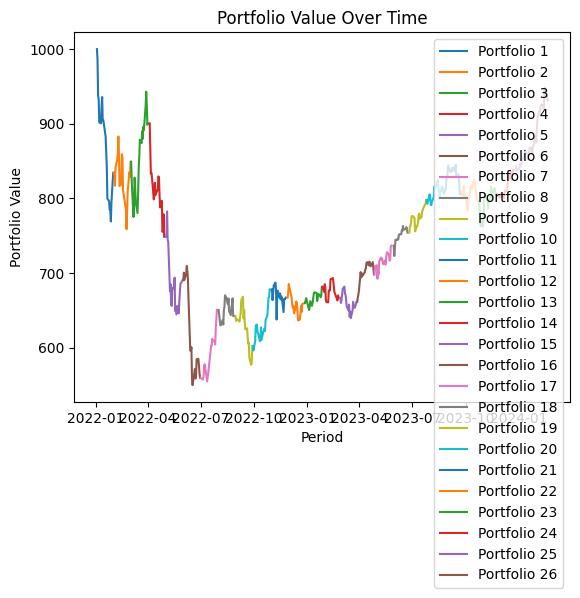

In [ ]:
# Plot each array in bl_portfolio
for i, portfolio_values in enumerate(bl_portfolio):
    plt.plot(portfolio_values, label=f'Portfolio {i+1}')

plt.xlabel('Period')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

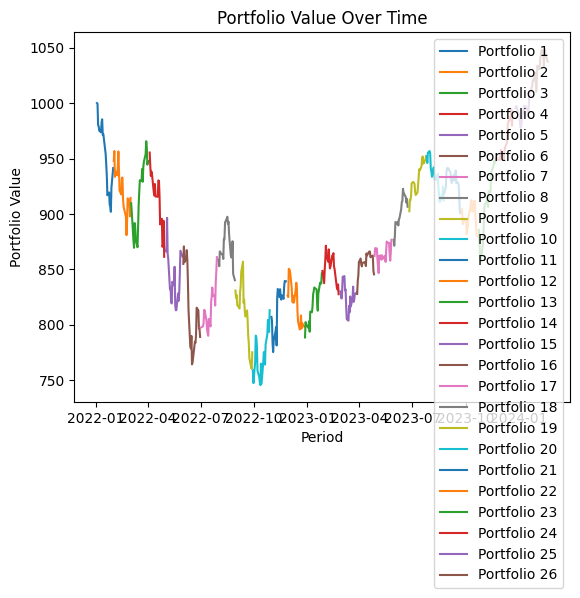

In [ ]:
# Plot each array in bl_portfolio
for i, portfolio_values in enumerate(market):
    plt.plot(portfolio_values, label=f'Portfolio {i+1}')

plt.xlabel('Period')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

In [ ]:
#convert to a dataframe
df_portfolio=pd.DataFrame(bl_portfolio)
# Replace all the nan to value 0. When you do a dataframe it will create several row per each run and the columns are the dates
df_portfolio.fillna(0, inplace=True)
#transpose to have the date as row and all the run as columns
df_portfolio = df_portfolio.transpose()
#sum all the columns in the same row to have and unique value per row
df_portfolio = df_portfolio.sum(axis=1)

start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")
sp500 = yf.download("^GSPC",start=start,end=end)['Adj Close']
market=sp500/sp500[0]*Total_invest_market

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

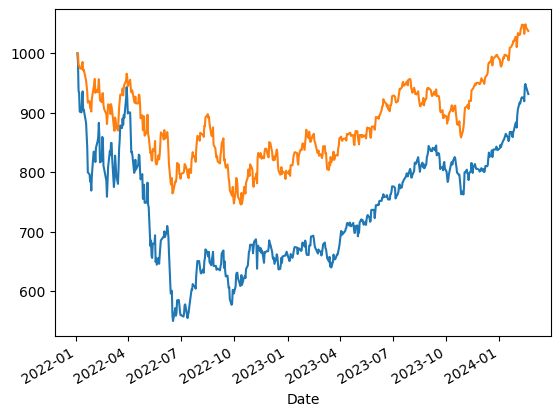

In [ ]:
df_portfolio.plot()
market.plot()

In [ ]:
df=pd.DataFrame(weights, columns=assets)

In [ ]:
import plotly.express as px

# Assuming df is your DataFrame with data
fig = px.bar(df, barmode='stack')
fig.update_layout(
    title='Stacked Bar Chart',
    xaxis=dict(title='Category'),
    yaxis=dict(title='Values'),
    legend=dict(title='Assets'),
)
# Create dropdown menu for variable selection
buttons = [
    dict(label=var, method='update', args=[{'visible': [col == var for col in df.columns]}])
    for var in df.columns
]
# Add an option to reset the graph
buttons.append(
    dict(label="Reset", method="update", args=[{'visible': [True] * len(df.columns)}])
)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.15,
            yanchor='top'
        ),
    ]
)
fig.show()